# Demo of base plots

## Installation

Make sure to follow the instructions in the `README.md` to install this package locally.

In [1]:
import pint_xarray
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from mom6_plots.base_plots import map_plot, timeseries_plot

## Loading some OM4 data

We will be using an example stored on the LEAP-Pangeo Cloud buckets. This will be accessible for anyone from the [LEAP-Pangeo Jupyterhub](https://leap-stc.github.io/tutorials/getting_started.html#).

In [2]:
# example output (from README)
import fsspec
import xarray as xr

zarr_data_path = 'gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr'
nc_grid_path = 'gs://leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc'

ds_raw = xr.open_dataset(zarr_data_path, engine='zarr', chunks={})

with fsspec.open(nc_grid_path) as f:
    ds_grid = xr.open_dataset(f).load().drop_vars('time')
ds_grid = ds_grid.set_coords(ds_grid.data_vars)

# from https://github.com/m2lines/ocean_emulators/issues/17
dz = xr.DataArray(
    [
        5,
        10,
        15,
        20,
        30,
        50,
        70,
        100,
        150,
        200,
        250,
        300,
        400,
        500,
        600,
        800,
        1000,
        1000,
        1000,
    ],
    dims=["lev"],
)


ds = xr.merge([ds_raw, ds_grid]).assign_coords(dz=dz)
ds

<xarray.Dataset> Size: 2TB
Dimensions:       (lev: 19, nv: 2, time: 4745, xh: 1440, xq: 1441, yh: 1080,
                   yq: 1081)
Coordinates: (12/35)
  * lev           (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * xh            (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq            (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh            (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
    ...            ...
    dyCv          (yq, xh) float32 6MB nan nan nan nan ... 246.8 148.7 49.76
    areacello_cu  (yh, xq) float32 6MB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    areacello_cv  (yq, xh) float32 6MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    areacello_bu  (yq, xq) float32 6MB nan nan nan ... 1.203e+06 4.55e+05
    basin         (yh, xh) int32 6MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz            (lev) int64 152B 5 10 15 20 30 50 ... 600 800 1000 1000 1000
Data variables:
    hfds          (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    so            (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    tauuo         (time, yh, xq) float32 30GB dask.array<chunksize=(1, 1080, 1441), meta=np.ndarray>
    tauvo         (time, yq, xh) float32 30GB dask.array<chunksize=(1, 1081, 1440), meta=np.ndarray>
    thetao        (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    time_bnds     (time, nv) object 76kB dask.array<chunksize=(1500, 2), meta=np.ndarray>
    uo            (time, lev, yh, xq) float32 561GB dask.array<chunksize=(1, 19, 1080, 1441), meta=np.ndarray>
    vo            (time, lev, yq, xh) float32 561GB dask.array<chunksize=(1, 19, 1081, 1440), meta=np.ndarray>
    zos           (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_5daily_cycle1

## Diagnosing Ocean Heat Content Metrics

These are some examples for potential metrics that could be calculated as a standard for MOM6 data. 

In [3]:
# Calculate a timeseries of 

def ohc_timeseries(ds):
    cp = 4000
    rho = 1035
    t =  ds.thetao
    
    int_t = t.weighted(ds.dz*ds.areacello).sum(['lev','xh','yh']).squeeze()
    ohc = rho*cp*int_t
    ohc.name = 'ohc'
    # These attribute is used to label the colorbar in the resulting plot!
    ohc.attrs['long_name'] = f'Integrated Ocean Heat Content'
    ohc.attrs['units'] = 'J'
    return ohc

def delta_ohc(ds) -> xr.DataArray:
    ds_cut = ds.thetao.isel(time=[0,-1])
    cp = 4000
    rho = 1035
    delta_t = ds_cut.diff('time')
    int_delta_t = delta_t.weighted(ds.dz).sum('lev').squeeze()
    ohc = rho*cp*int_delta_t
    ohc.name = 'ohc'
    # These attribute is used to label the colorbar in the resulting plot!
    ohc.attrs['long_name'] = f'Change in Ocean Heat Content \n{ds_cut.time.data[0].strftime("%Y-%m-%d")} to {ds_cut.time.data[1].strftime("%Y-%m-%d")}'
    ohc.attrs['units'] = 'J/(m^2)'
    return ohc

## use the provided plotting functions

### Timeseries

In [4]:
ohc_t1 = ohc_timeseries(ds.isel(time=slice(0,100)))
ohc_t2 = ohc_t1 * 1.02 # just multiply with a dummy value to show them as separate timeseries

/home/jovyan/PROJECTS/MOM6-diags/mom6-plots/mom6_plots/base_plots.py:31: UserWarning: No `ax` input provided. Using the current axis.
  warnings.warn('No `ax` input provided. Using the current axis.')


<Axes: xlabel='time', ylabel='ohc'>

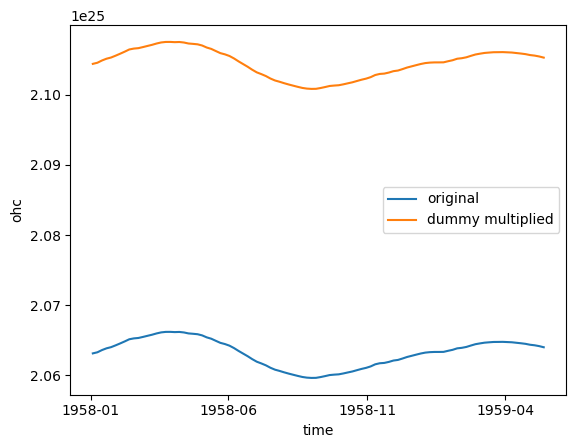

In [5]:
timeseries_plot(ohc_t1, ohc_t2, labels=['original','dummy multiplied'])

## Map

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: title={'center': 'time = 2022-12-29 12:00:00'}, xlabel='lon', ylabel='lat'>

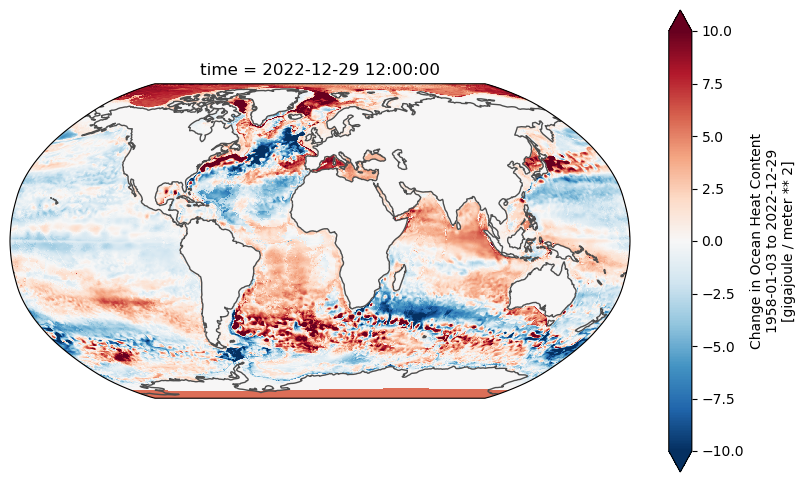

In [6]:
d_ohc = delta_ohc(ds)

# convert units to GJ/m^2
d_ohc = d_ohc.pint.quantify().pint.to('GJ/(m^2)').pint.dequantify()

fig,ax = plt.subplots(
    figsize=[10,6],
    subplot_kw=dict(projection=ccrs.Robinson())
)

map_plot(d_ohc, ax=ax, vmax=10)

That is the demo for now. Still a bunch of things to tweak obviously, but lets make this a community process!
If you have suggestions, critique, comments, please [raise an issue](https://github.com/m2lines/mom6-plots/issues). 

## Bonus feature for presentations: m2lines logo

Makes it easy to carry credit for our work when sharing plots/slides.

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: title={'center': 'time = 2022-12-29 12:00:00'}, xlabel='lon', ylabel='lat'>

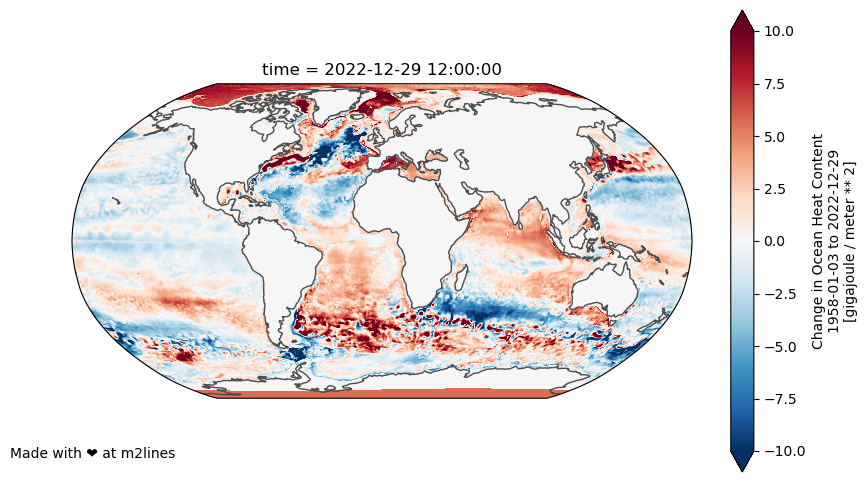

In [7]:
fig,ax = plt.subplots(
    figsize=[10,6],
    subplot_kw=dict(projection=ccrs.Robinson())
)

map_plot(d_ohc, ax=ax, vmax=10, logo=True)

/home/jovyan/PROJECTS/MOM6-diags/mom6-plots/mom6_plots/base_plots.py:31: UserWarning: No `ax` input provided. Using the current axis.
  warnings.warn('No `ax` input provided. Using the current axis.')


<Axes: xlabel='time', ylabel='ohc'>

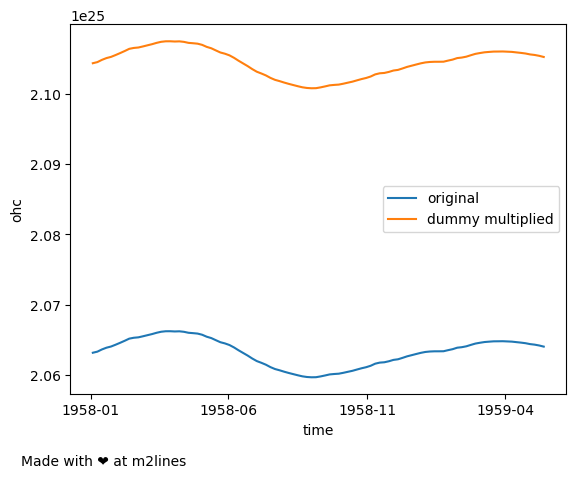

In [8]:
timeseries_plot(ohc_t1, ohc_t2, labels=['original','dummy multiplied'], logo=True)